Lesson 4

In [1]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [2]:
# Creating the Pathlib PATH objects
train_path = Path("./train")
test_path = Path("./test")

In [3]:
# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['train\\angry\\Training_10118481.jpg',
 'train\\angry\\Training_10120469.jpg',
 'train\\angry\\Training_10131352.jpg',
 'train\\angry\\Training_10161559.jpg',
 'train\\angry\\Training_1021836.jpg',
 'train\\angry\\Training_10269675.jpg',
 'train\\angry\\Training_10278738.jpg',
 'train\\angry\\Training_10290703.jpg',
 'train\\angry\\Training_10295477.jpg',
 'train\\angry\\Training_10315441.jpg']

In [4]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-1]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['train\\angry\\Training_10118481.jpg',
 'train\\angry\\Training_10120469.jpg',
 'train\\angry\\Training_10131352.jpg',
 'train\\angry\\Training_10161559.jpg',
 'train\\angry\\Training_1021836.jpg',
 'train\\angry\\Training_10269675.jpg',
 'train\\angry\\Training_10278738.jpg',
 'train\\angry\\Training_10290703.jpg',
 'train\\angry\\Training_10295477.jpg',
 'train\\angry\\Training_10315441.jpg']

In [5]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [6]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [8]:
# Compute class weights 

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.0, 1: inf, 2: inf, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: inf, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: inf, 21: inf, 22: inf, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: inf, 28: 1.0, 29: 1.0, 30: inf, 31: 1.0, 32: 1.0, 33: 1.0, 34: inf, 35: 1.0, 36: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 40: 1.0, 41: inf, 42: 1.0, 43: 1.0, 44: 1.0, 45: 1.0, 46: inf, 47: 1.0, 48: 1.0, 49: 1.0, 50: 1.0, 51: inf, 52: inf, 53: inf, 54: 1.0, 55: inf, 56: inf, 57: inf, 58: 1.0, 59: 1.0, 60: inf, 61: 1.0, 62: inf, 63: 1.0, 64: inf, 65: 1.0, 66: inf, 67: 1.0, 68: 1.0, 69: inf, 70: inf, 71: inf, 72: 1.0, 73: 1.0, 74: inf, 75: inf, 76: 1.0, 77: 1.0, 78: 1.0, 79: inf, 80: 1.0, 81: 1.0, 82: 1.0, 83: 1.0, 84: 1.0, 85: 1.0, 86: 1.0, 87: 1.0, 88: 1.0, 89: 1.0, 90: 1.0, 91: 1.0, 92: 1.0, 93: 1.0, 94: 1.0, 95: inf, 96: 1.0, 97: 1.0, 98: 1.0, 99: 1.0, 100: 1.0, 101: inf, 102: 1.0, 103: 1.0, 104: 1.0, 105: 1.0, 106: 1.0, 107: 1.0, 108: 1.0, 109: 1.0, 110: 1.0,

<ipython-input-8-ccf36c1a759b>:4: RuntimeWarning: divide by zero encountered in true_divide
  classWeight = classTotals.max() / classTotals


Lesson 5

In [9]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [10]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [11]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [12]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

Wall time: 323 ms
(32, 96, 96, 3)
(32, 28709)


train\fear\Training_99735235.jpg


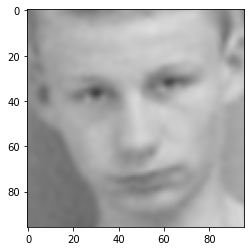

In [13]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [14]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

Wall time: 135 ms
(32, 96, 96, 3)
(32, 28709)


train\fear\Training_92127745.jpg


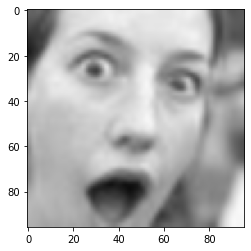

In [15]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [16]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 3, 3, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 7,949,824
Trainable params: 7,882,249
Non-trainable params: 67,575
_________________________________________________________________


In [17]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [18]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12


ValueError: in user code:

    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 28709) and (None, 7) are incompatible


In [28]:
model.layers[0].trainable = False

In [29]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 3, 3, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
_________________________________________________________________


In [31]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8


ValueError: in user code:

    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\ataas\anaconda3\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\ataas\anaconda3\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\ataas\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 28709) and (None, 7) are incompatible


Testing Phase

In [32]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [33]:
model.load_weights("best_weights.h5")

In [34]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

ValueError: y contains previously unseen labels: 'test\\angry\\PrivateTest_10131363.jpg'

In [35]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

NameError: name 'test_dataset' is not defined

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

Save Objects

In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")

In [ ]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")